In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
np.random.seed(125)


**Embeddings from google sentence encoder**

In [0]:
# Functions
def convert_to_one_hot(Y, C):
  Y = np.eye(C)[Y.reshape(-1)]
  return Y

# for padding
def fix(arr,pad_s = 50):
  dif = pad_s - arr.shape[0]
  temp = np.concatenate((arr, np.zeros((dif,512))))
  return temp

def acc_plot(history):
  # summarize history for accuracy
  print('========='*10)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def loss_plot(history):
  # summarize history for loss
  print('========='*10)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


### Dataset Preview

In [5]:
df = pd.read_csv('drive/My Drive/CSV/train.csv'
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [11]:
print('Real\tFake\n{}\t{}'.format(df['label'].value_counts()[0],df['label'].value_counts()[1]))

Real	Fake
10387	10413


In [0]:
# Article Embeddings made from Google Universal Sentence Encoder
real_art = np.load('drive/My Drive/CSV/emb/kaggle_dataset/k_real_art_emb.npy')
fake_art = np.load('drive/My Drive/CSV/emb/kaggle_dataset/k_fake_art_emb.npy')
data = np.concatenate((real_art,fake_art),axis=0)
print('Type\tCounts\n{}\t{}\n{}\t{}'.format('Real',len(real_art),'Fake',len(fake_art)))

Type	Counts
Real	6200
Fake	6200


In [0]:
# Contains Total of 12400 articles 
# Each article has maximum of 50 Sentences (which are padded if less)
# Each sentence is represented by a vector of size (512,) 
data.shape

(12400, 50, 512)

In [0]:
# One hot representation of Labels
Y = convert_to_one_hot(np.append(np.zeros((6200,),dtype=int),np.ones((6200,),dtype=int)),2) # reliable [1,0] fake [0,1]
print(Y[0],Y[6900],sep='\n')

[1. 0.]
[0. 1.]


### ** Train - Test**

In [0]:
# Train Test
xTrain, xTest, yTrain, yTest = train_test_split(data, Y, test_size = 0.2, random_state = 125)

In [0]:

# First 5 labels 
yTest[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [0]:
print("Train Size - {}, Test size - {} ".format(yTrain.shape[0],yTest.shape[0]))

Train Size - 9920, Test size - 2480 


In [0]:
xTrain.shape

(8878, 50, 512)

In [0]:
unique, counts = np.unique(yTest[:,0], return_counts=True)
unique, counts

(array([0., 1.]), array([1245, 1235]))

In [0]:
# Will be used in callbacks in keras model.fit
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

## **Model v1**
Simple Single Layer LSTM followed by a dense layer.
- LSTM layer takes input a 3d vector which has 50 timesteps, 512 Features, 1 or more samples
- LSTM layer is the input layer in this case
- Embeddings are directly fed into it.

In [0]:
modelv1 = Sequential()
modelv1.add(LSTM(256, input_shape=(50, 512), return_sequences=False,activity_regularizer=l1(0.0001)))
modelv1.add(Dropout(0.5))
modelv1.add(Dense(2, activation='softmax'))
modelv1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelv1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 787,970
Trainable params: 787,970
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history_v1 = modelv1.fit(xTrain, yTrain, epochs=5, validation_data=(xTest, yTest), batch_size=64,validation_split=0.2, callbacks = [es])

Train on 9920 samples, validate on 2480 samples
Epoch 1/5
9920/9920 [==============================] - 27s 3ms/step - loss: 0.4906 - acc: 0.7877 - val_loss: 0.4074 - val_acc: 0.8496
Epoch 2/5
9920/9920 [==============================] - 24s 2ms/step - loss: 0.3560 - acc: 0.8742 - val_loss: 0.3779 - val_acc: 0.8516
Epoch 3/5
9920/9920 [==============================] - 24s 2ms/step - loss: 0.3045 - acc: 0.8944 - val_loss: 0.3097 - val_acc: 0.8948
Epoch 4/5
9920/9920 [==============================] - 24s 2ms/step - loss: 0.2701 - acc: 0.9098 - val_loss: 0.2707 - val_acc: 0.9056
Epoch 5/5
9920/9920 [==============================] - 24s 2ms/step - loss: 0.2336 - acc: 0.9253 - val_loss: 0.2396 - val_acc: 0.9250


In [0]:
loss, acc = modelv1.evaluate(xTest, yTest)
print()
print("Test accuracy = ", acc)

2480/2480 [==============================] - 5s 2ms/step

Test accuracy =  0.925


## **Model v2**
- Double layered LSTM with dropout and dense.


In [0]:
# MODEl v2
# Change number of units in LSTM 
modelv2 = Sequential()
modelv2.add(LSTM(256, input_shape=(50, 512), return_sequences=True))
modelv2.add(Dropout(0.5)) # change to see different results
modelv2.add(LSTM(256, input_shape=(50, 512), return_sequences=False,activity_regularizer=l1(0.0001)))
modelv2.add(Dropout(0.5))
modelv2.add(Dense(2, activation='softmax')) # check softmax or other function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
#adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
modelv2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(modelv2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 256)           787456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 1,313,282
Trainable params: 1,313,282
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%%time
historyv2 = modelv2.fit(xTrain, yTrain, epochs=5, validation_data=(xTest, yTest), validation_split=0.2, batch_size=64)

Train on 9920 samples, validate on 2480 samples
Epoch 1/5
9920/9920 [==============================] - 48s 5ms/step - loss: 0.4801 - acc: 0.8000 - val_loss: 0.4083 - val_acc: 0.8355
Epoch 2/5
9920/9920 [==============================] - 46s 5ms/step - loss: 0.3632 - acc: 0.8703 - val_loss: 0.3276 - val_acc: 0.8879
Epoch 3/5
9920/9920 [==============================] - 46s 5ms/step - loss: 0.3000 - acc: 0.8988 - val_loss: 0.3182 - val_acc: 0.8968
Epoch 4/5
9920/9920 [==============================] - 46s 5ms/step - loss: 0.2652 - acc: 0.9110 - val_loss: 0.2579 - val_acc: 0.9133
Epoch 5/5
9920/9920 [==============================] - 46s 5ms/step - loss: 0.2344 - acc: 0.9252 - val_loss: 0.2498 - val_acc: 0.9190
CPU times: user 4min 48s, sys: 35.7 s, total: 5min 24s
Wall time: 3min 55s


In [0]:
loss, acc = modelv2.evaluate(xTest, yTest)
print()
print('Test Accuracy : {}\nLoss : {}'.format(acc,loss))

2480/2480 [==============================] - 9s 4ms/step

Test Accuracy : 0.9189516129032258
Loss : 0.23113962344584926


## **Model v3**
- Added conv layer on top of LSTM stack. layer 1 learns more spatial relationship. Architecture after this is same as model v1.

In [0]:
modelv3 = Sequential()
modelv3.add(Conv1D(input_shape=(50, 512),filters=512, kernel_size=3, padding='same', activation='relu'))
modelv3.add(MaxPooling1D(pool_size=2))
modelv3.add(LSTM(256, input_shape=(50, 512), return_sequences=False,activity_regularizer=l1(0.0001)))
modelv3.add(Dropout(0.5))
modelv3.add(Dense(2, activation='softmax'))
modelv3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelv3.summary())




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 512)           786944    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 1,574,914
Trainable params: 1,574,914
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%%time
historyv3 = modelv3.fit(xTrain, yTrain, epochs=5, validation_data=(xTest, yTest), batch_size=64, validation_split=0.2, callbacks = [es])

Train on 9920 samples, validate on 2480 samples
Epoch 1/5
9920/9920 [==============================] - 20s 2ms/step - loss: 0.3910 - acc: 0.8521 - val_loss: 0.2816 - val_acc: 0.9089
Epoch 2/5
9920/9920 [==============================] - 16s 2ms/step - loss: 0.2231 - acc: 0.9389 - val_loss: 0.2317 - val_acc: 0.9294
Epoch 3/5
9920/9920 [==============================] - 16s 2ms/step - loss: 0.1794 - acc: 0.9556 - val_loss: 0.2350 - val_acc: 0.9266
Epoch 4/5
9920/9920 [==============================] - 16s 2ms/step - loss: 0.1276 - acc: 0.9734 - val_loss: 0.2265 - val_acc: 0.9331
Epoch 5/5
9920/9920 [==============================] - 16s 2ms/step - loss: 0.1025 - acc: 0.9809 - val_loss: 0.1773 - val_acc: 0.9476
CPU times: user 1min 34s, sys: 12.7 s, total: 1min 46s
Wall time: 1min 25s


In [0]:
loss, acc = modelv3.evaluate(xTest, yTest)
print()
print('Test accuracy : {} \nLoss : {}'.format(acc,loss))

2480/2480 [==============================] - 3s 1ms/step

Test accuracy : 0.9475806451612904 
Loss : 0.15891707594836912


## **Model v4**

- Added conv layer as input layer.. after which RNN.. v2

In [0]:
modelv4 = Sequential()
modelv4.add(Conv1D(input_shape=(50, 512),filters=512, kernel_size=3, padding='same', activation='relu'))
modelv4.add(MaxPooling1D(pool_size=2))
modelv4.add(LSTM(512, input_shape=(50, 512), return_sequences=True))
modelv4.add(Dropout(0.5)) # change to see different results
modelv4.add(LSTM(512, input_shape=(50, 512), return_sequences=False, activity_regularizer=l1(0.0001)))
modelv4.add(Dropout(0.5))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
#adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
modelv4.add(Dense(2, activation='softmax')) # check softmax or other function
modelv4.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])
print(modelv4.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 50, 512)           786944    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 25, 512)           2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 25, 512)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total para

In [0]:
%%time
historyv4 = modelv4.fit(xTrain, yTrain, epochs=5, validation_data=(xTest, yTest), batch_size=64, validation_split=0.2, callbacks = [es])

Train on 9920 samples, validate on 2480 samples
Epoch 1/5
9920/9920 [==============================] - 33s 3ms/step - loss: 0.3805 - acc: 0.8714 - val_loss: 0.2579 - val_acc: 0.9274
Epoch 2/5
9920/9920 [==============================] - 30s 3ms/step - loss: 0.2277 - acc: 0.9390 - val_loss: 0.2267 - val_acc: 0.9258
Epoch 3/5
9920/9920 [==============================] - 30s 3ms/step - loss: 0.1778 - acc: 0.9563 - val_loss: 0.1891 - val_acc: 0.9440
Epoch 4/5
9920/9920 [==============================] - 30s 3ms/step - loss: 0.1319 - acc: 0.9725 - val_loss: 0.2036 - val_acc: 0.9339
Epoch 5/5
9920/9920 [==============================] - 30s 3ms/step - loss: 0.1080 - acc: 0.9788 - val_loss: 0.1706 - val_acc: 0.9524
CPU times: user 3min, sys: 26.1 s, total: 3min 26s
Wall time: 2min 37s


In [0]:
loss, acc = modelv4.evaluate(xTest, yTest)
print()
print('Test accuracy = {} \n loss - {}'.format(acc,loss))

2480/2480 [==============================] - 5s 2ms/step

Test accuracy = 0.9524193548387097 
 loss - 0.15076583123976184


## **Results and Evaluation**

### Modelv1

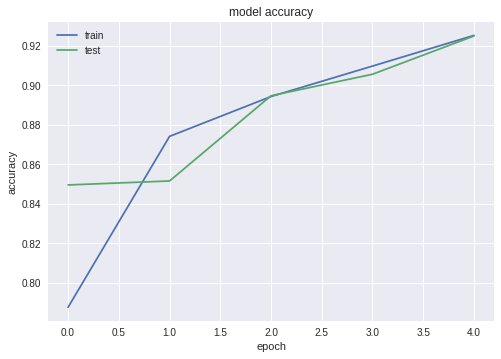

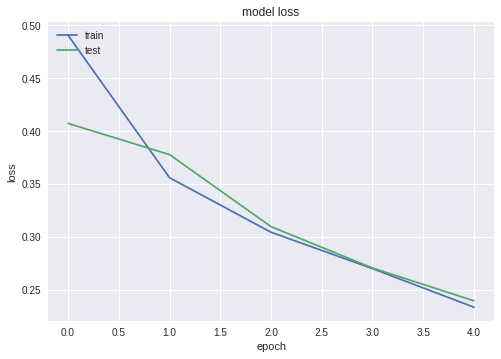

(None, None)

In [0]:
acc_plot(history_v1),loss_plot(history_v1)

### Modelv2

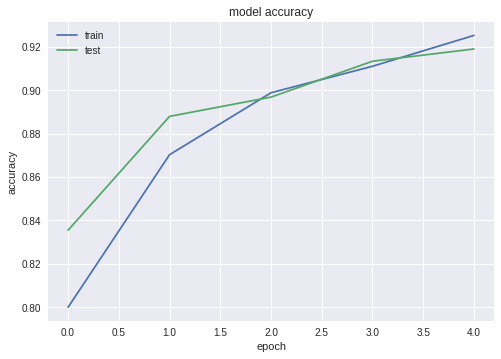

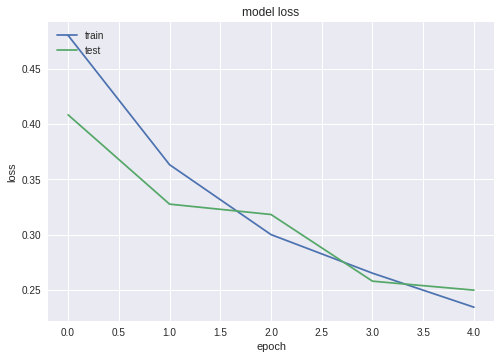

(None, None)

In [0]:
acc_plot(historyv2),loss_plot(historyv2)

### Modelv3

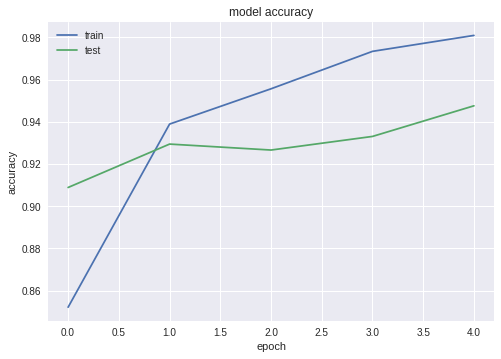

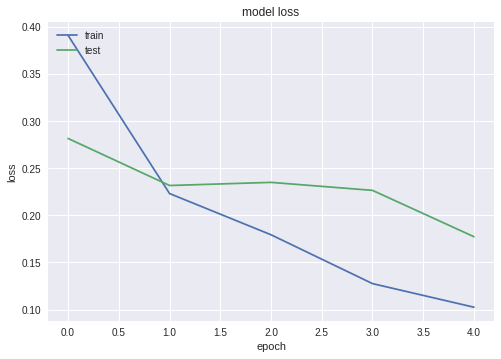

(None, None)

In [0]:
acc_plot(historyv3),loss_plot(historyv3)

### Modelv4

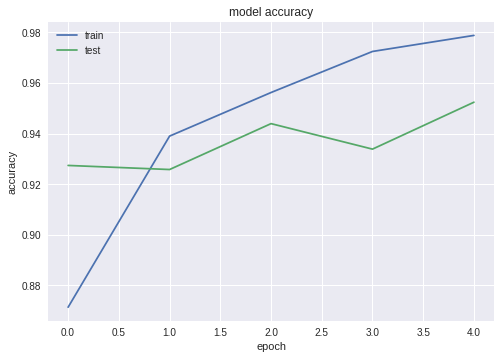

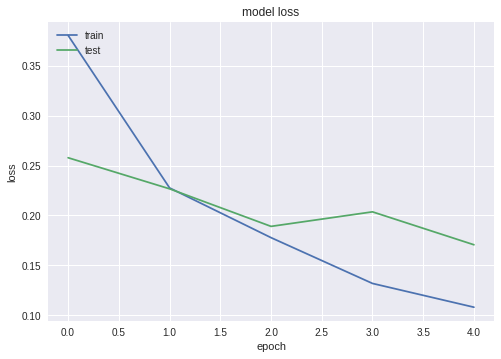

(None, None)

In [0]:
acc_plot(historyv4),loss_plot(historyv4)

In [0]:
def model_eval(msg, model,test_data,test_labels):
  print('Evaluation of: ',msg)
  dash_length = len('Evaluation of Model')
  print('---'*dash_length)
  y_Pred = model.predict(test_data)
  y_Pred = y_Pred[:,0] > 0.5
  y_Test = test_labels[:,0] > 0.5
  cm = confusion_matrix(y_Test, y_Pred)
  print(cm)
  print(classification_report(y_Test, y_Pred, target_names=['Real', 'Fake']))
  print('---'*dash_length)

In [0]:
model_eval('Modelv1',modelv1,xTest,yTest)
model_eval('Modelv2',modelv2,xTest,yTest)
model_eval('Modelv3',modelv3,xTest,yTest)
model_eval('Modelv4',modelv4,xTest,yTest)

Evaluation of:  Modelv1
---------------------------------------------------------
[[1142  103]
 [  83 1152]]
              precision    recall  f1-score   support

        Real       0.93      0.92      0.92      1245
        Fake       0.92      0.93      0.93      1235

   micro avg       0.93      0.93      0.93      2480
   macro avg       0.93      0.93      0.92      2480
weighted avg       0.93      0.93      0.92      2480

---------------------------------------------------------
Evaluation of:  Modelv2
---------------------------------------------------------
[[1162   83]
 [ 118 1117]]
              precision    recall  f1-score   support

        Real       0.91      0.93      0.92      1245
        Fake       0.93      0.90      0.92      1235

   micro avg       0.92      0.92      0.92      2480
   macro avg       0.92      0.92      0.92      2480
weighted avg       0.92      0.92      0.92      2480

---------------------------------------------------------
Evaluation o

# Generalization required.
Work needed to be done to improve model performance.